In [1]:
"""
Master Notebook V2 
"""

'\nMaster Notebook V2 \n'

In [2]:
"""Imports
"""
import pandas as pd 
from pathlib import Path 
from dotenv import load_dotenv 
import os
import matplotlib 
import matplotlib.pyplot as plt
import hvplot.pandas
import numpy as np
import alpaca_trade_api as tradeapi
import panel as pn
from datetime import datetime
import requests
import seaborn as sns
from sklearn.linear_model import LinearRegression


from scipy import stats
import operator 


In [3]:

#Loading in my environments: dotenv an 

load_dotenv("api.env")
APCA_API_BASE_URL = "https://paper-api.alpaca.markets" 


#Setting up my Alpaca API Keys and creating the Alpaca API object: 

apikey = os.getenv("ALPACA_API_KEY")
secret = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    apikey, secret,
    api_version = "v2"
)



#Calling in my securities and setting up a mock portfolio 

assets = ["ARKK","SPY","IWM"]


#Getting my ticker information from Alpaca API 

timeframe = "1Day"
start_date = pd.Timestamp("2018-12-31", tz = "America/New_York").isoformat()
end_date = pd.Timestamp("2023-12-29", tz = "America/New_York").isoformat()

#Getting my ticker information for the funds: ARKK and SPY 

df_assets = api.get_bars(
    assets,
    timeframe,
    start = start_date,
    end = end_date
).df 

# df_assets.head()

#Dropped column head: Symbol and made SPY & ARKK the symbol head 
SPY = df_assets[df_assets['symbol'] == 'SPY'].drop('symbol', axis = 1)
ARKK = df_assets[df_assets['symbol'] == 'ARKK'].drop('symbol', axis = 1)
IWM = df_assets[df_assets['symbol'] == 'IWM'].drop('symbol', axis = 1) 

#Concat the dataframe to show SPY & ARKK as the column head. 
df_assets_concat = pd.concat([SPY, ARKK, IWM], axis = 1, keys = ["SPY","ARKK", "IWM"])
# df_assets_concat

#Setting up a blank dataframe to input my ARKK & SPY 
df_ARKK_SPY = pd.DataFrame() 

#Isolated the SPY and ARKK close dates 
df_ARKK_SPY["SPY"] = df_assets_concat["SPY"]["close"]
df_ARKK_SPY["ARKK"] = df_assets_concat["ARKK"]["close"]
df_ARKK_SPY["IWM"] = df_assets_concat["IWM"]["close"]

#Dropped the time index from the date 
df_ARKK_SPY.index = df_ARKK_SPY.index.date
# df_ARKK_SPY.head()

#Calculated the daily returns of ARKK & SPY 
df_ARKK_SPY_daily = df_ARKK_SPY.pct_change().dropna()
# df_ARKK_SPY_daily.head()

#Plotting the daily returns 
df_ARKK_SPY_daily.hvplot.line(title = "ARKK, SPY, IWM Daily Returns")

######

df_ARKK_SPY.head()

,SPY,ARKK,IWM
2018-12-31,250.08,37.19,133.900
2019-01-02,250.23,37.42,134.695
2019-01-03,244.15,36.19,132.310
2019-01-04,252.39,38.43,137.210
2019-01-07,254.29,40.10,139.630


In [4]:
"""Aditya's Section - Data
"""


def get_historical_bitcoin_data(start_date, end_date):
    # Convert start and end dates to Unix timestamp
    start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp())
    end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    # Calculate the number of days between start and end dates
    days_difference = (end_timestamp - start_timestamp) // (24 * 3600) # seconds in a day
    # API endpoint for historical prices
    api_url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'
    # Define parameters for the API request
    params = {
        'vs_currency': 'usd',
        'from': start_timestamp * 1000, # Multiply by 1000 for milliseconds
        'to': end_timestamp * 1000, # Multiply by 1000 for milliseconds
        'days': days_difference # Add the 'days' parameter
     }
    # Make the API request
    response = requests.get(api_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        prices = data.get('prices', [])
        return prices
    else:
        print(f"Failed to retrieve Bitcoin data. Status code: {response.status_code}")
        print(f"Error message: {response.text}")
    return None
    
# Set the date range
start_date = '2018-12-31'
end_date = '2023-12-29'
# Get historical Bitcoin data
bitcoin_prices = get_historical_bitcoin_data(start_date, end_date)
# Display the results in a simple table format

dates = [] 
prices_btc = []

if bitcoin_prices:
    # print("{:<20} {:<15}".format("Date", "Price (USD)"))
    for timestamp, price in bitcoin_prices:
        date_str = datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d')
        if date_str <= end_date:
            dates.append(date_str)
            prices_btc.append(price)
            #print("{:<20} {:<15.2f}".format(date_str, price))

# format = '%Y-%m-%d'
# for i in dates:
#     datetime.datetime.strptime(i, format).date()

# df_bitcoin = pd.DataFrame(prices_btc, dates)

# df_bitcoin.head()

df_bitcoin_raw = pd.DataFrame(
    {"Date":dates,
     "BTC":prices_btc}
)
df_bitcoin_set = df_bitcoin_raw.set_index("Date")
df_bitcoin_set


,BTC
Date,
2019-02-16,3622.591653
2019-02-17,3665.075531
2019-02-18,3886.520200
2019-02-19,3915.009971
2019-02-20,3976.808907
...,...
2023-12-25,43638.236302
2023-12-26,42516.426940
2023-12-27,43418.467775


In [5]:
"""Antonio Section - Data
"""
csvpath = Path('FGRTX.csv')
fgrtx_df = pd.read_csv(csvpath)
# fgrtx_df.head()

#Sorting by "Date" 
# Sort data by `Date` in ascending order
fgrtx_df = fgrtx_df.sort_values("Date", ascending=True)
# fgrtx_df.head()

#Converted into datetime 
fgrtx_df.set_index(pd.to_datetime(fgrtx_df['Date'], infer_datetime_format=True), inplace=True)
fgrtx_df.head()



/var/folders/jm/yl4jhp9j0z1b4xdws78jvgjc0000gn/T/ipykernel_9592/343014348.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fgrtx_df.set_index(pd.to_datetime(fgrtx_df['Date'], infer_datetime_format=True), inplace=True)


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2019-01-02,2019-01-02,13.59,13.59,13.59,13.59,9.782362,0
2019-01-03,2019-01-03,13.37,13.37,13.37,13.37,9.624000,0
2019-01-04,2019-01-04,13.78,13.78,13.78,13.78,9.919126,0
2019-01-07,2019-01-07,13.84,13.84,13.84,13.84,9.962316,0
2019-01-08,2019-01-08,13.94,13.94,13.94,13.94,10.034297,0


In [6]:
#Drop the column
fgrtx_df.drop(columns=['Date','Open','High','Low','Close','Volume'], inplace=True)
fgrtx_df.head()

# Count nulls
fgrtx_df.isnull().sum()
# Drop nulls
fgrtx_df = fgrtx_df.dropna().copy()
fgrtx_df




,Adj Close
Date,
2019-01-02,9.782362
2019-01-03,9.624000
2019-01-04,9.919126
2019-01-07,9.962316
2019-01-08,10.034297
...,...
2023-12-22,20.889999
2023-12-26,20.969999
2023-12-27,20.980000


In [7]:
#Check nulls
fgrtx_df.isnull().sum()




Adj Close    0
dtype: int64

In [8]:
#Check datatypes
fgrtx_df.dtypes

Adj Close    float64
dtype: object

In [9]:
# Rename `Close` Column to be specific to this portfolio.
fgrtx_df = fgrtx_df.rename(columns={
    "Adj Close": "FGRTX"
   })

fgrtx_df.head()

,FGRTX
Date,
2019-01-02,9.782362
2019-01-03,9.624000
2019-01-04,9.919126
2019-01-07,9.962316
2019-01-08,10.034297


In [10]:
# Calculate the daily return using the 'pct_change()' function
daily_returns_fgrtx = fgrtx_df.pct_change()
daily_returns_fgrtx.head()

,FGRTX
Date,
2019-01-02,NaN
2019-01-03,-0.016189
2019-01-04,0.030666
2019-01-07,0.004354
2019-01-08,0.007225


In [11]:
# Drop nulls
daily_returns_fgrtx = daily_returns_fgrtx.dropna().copy()
daily_returns_fgrtx

# Rename `Close` Column to be specific to this portfolio.
daily_returns_fgrtx = daily_returns_fgrtx.rename(columns={
    "Adj Close": "FGRTX"
   })

daily_returns_fgrtx.head()


,FGRTX
Date,
2019-01-03,-0.016189
2019-01-04,0.030666
2019-01-07,0.004354
2019-01-08,0.007225
2019-01-09,0.004304


In [12]:
#plot daily returns FGRTX

plot_daily_returns_fgrtx=daily_returns_fgrtx.hvplot(figsize=(10,5))
daily_returns_fgrtx.hvplot(kind="line")

:Curve   [Date]   (FGRTX)

In [13]:

# Set File path
csvpath = Path('EFFR.csv')

effr_df = pd.read_csv(csvpath)
effr_df.head()

# Sort data by `Date` in ascending order
effr_df = effr_df.sort_values("Effective Date", ascending=True)
effr_df.head()

# Rename `Close` Column to be specific to this portfolio.
effr_df = effr_df.rename(columns={
    "Effective Date": "Date"
   })

effr_df.head()

#Set Date as Index
effr_df.set_index(pd.to_datetime(effr_df['Date'], infer_datetime_format=True), inplace=True)
effr_df.head()

effr_df_data=effr_df[["Rate (%)"]] #Only includes what's inside the [[]] 
effr_df_data.head()

effr_df_data = effr_df_data.dropna().copy()

#Rename `Close` Column to be specific to this portfolio.
effr_df_data = effr_df_data.rename(columns={
    "Rate (%)": "EFFR % Rate"
   })
effr_df_data.head()

effr_df_data.isnull().sum() 

effr_df_data = effr_df_data.sort_values("Date", ascending=True)
effr_df_data.tail()

effr_df_data_change = effr_df_data.copy()
effr_df_data_change.head()

effr_df_data_change['EFFR % Rate'] = effr_df_data_change['EFFR % Rate']/100
effr_df_data_change

/var/folders/jm/yl4jhp9j0z1b4xdws78jvgjc0000gn/T/ipykernel_9592/2711737802.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  effr_df.set_index(pd.to_datetime(effr_df['Date'], infer_datetime_format=True), inplace=True)


,EFFR % Rate
Date,
2018-12-31,0.0240
2019-01-02,0.0240
2019-01-03,0.0240
2019-01-04,0.0240
2019-01-07,0.0240
...,...
2023-12-22,0.0533
2023-12-26,0.0533
2023-12-27,0.0533


In [14]:
####Calculating the daily returns:

#FGRTX Mutual Fund Daily Returns
daily_returns_fgrtx 
fgrtx_df
#ARKK & SPY Daily Returns 
daily_returns_arkk_spy = df_ARKK_SPY.pct_change().dropna()
# daily_returns_arkk_spy.head()

#Bitcoin Prices 
daily_returns_bitcoin = df_bitcoin_set.pct_change().dropna()
# daily_returns_bitcoin.head()



In [15]:
#Set arkk_spy prices into date: 
df_ARKK_SPY_set = df_ARKK_SPY.reset_index()
df_ARKK_SPY_set['index'] = pd.to_datetime(df_ARKK_SPY_set["index"])
df_ARKK_SPY_set['Date'] = df_ARKK_SPY_set['index']

df_ARKK_SPY_set = df_ARKK_SPY_set.set_index('Date') 
# daily_returns_arkk_spy_set_dropped = 
df_ARKK_SPY_set.drop(columns=["index"], inplace=True)
df_ARKK_SPY_set.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [16]:
#Set BITCOIN prices into date: 
df_bitcoin_set_prices = df_bitcoin_set.reset_index()
df_bitcoin_set_prices["Date"] = pd.to_datetime(df_bitcoin_set_prices['Date'])

df_bitcoin_set_prices = df_bitcoin_set_prices.set_index('Date')
df_bitcoin_set_prices.index

DatetimeIndex(['2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23',
               '2019-02-24', '2019-02-25',
               ...
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-23',
               '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1778, freq=None)

In [17]:
#Concating the dataframes (Prices)
df_price_data_all_assets = pd.concat([fgrtx_df,df_ARKK_SPY_set, df_bitcoin_set_prices], axis=1, join='inner')
df_price_data_all_assets



,FGRTX,SPY,ARKK,IWM,BTC
Date,,,,,
2019-02-19,10.797307,277.88,45.22,156.65,3915.009971
2019-02-20,10.804506,278.43,45.59,157.39,3976.808907
2019-02-21,10.754117,277.46,44.70,156.80,3934.813594
2019-02-22,10.811703,279.16,45.77,158.15,3973.641323
2019-02-25,10.854893,279.59,46.39,158.19,3824.683504
...,...,...,...,...,...
2023-12-22,20.889999,473.65,53.01,201.48,44003.696022
2023-12-26,20.969999,475.65,53.79,204.10,42516.426940
2023-12-27,20.980000,476.51,54.26,204.82,43418.467775


In [18]:
#Change in 1 dollars over period 
df_price_data_all_assets_investment_inc_btc = df_price_data_all_assets.copy()
df_price_data_all_assets_investment_btc = df_price_data_all_assets_investment_inc_btc.pct_change()
df_price_data_all_assets_investment_btc = (1+df_price_data_all_assets_investment_btc).cumprod()

df_price_data_all_assets_investment_btc.hvplot(ylabel = "1 dollar investment change", title = "BTC outperforms all asset classes since 2019")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [19]:
#Change in 1 dollars over period _ex btc
df_price_data_all_assets_investment = df_price_data_all_assets.copy()
df_price_data_all_assets_investment_change = df_price_data_all_assets_investment.pct_change()
df_price_data_all_assets_investment_change = (1+df_price_data_all_assets_investment_change).cumprod()
df_performance_ex_btc = df_price_data_all_assets_investment_change.drop(columns = ["BTC"])

df_performance_ex_btc.hvplot(ylabel = "1 dollar investment change", title = "FGRTX outperforms all asset classes ex. btc since 2019")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [20]:
#Graph of Asset prices timeseries 2019-2023 
fgrtx_df_price_data=fgrtx_df.hvplot(kind="line")
df_ARKK_SPY_IWM_price_data=df_ARKK_SPY_set.hvplot(kind="line")
df_bitcoin_set_prices_data=df_bitcoin_set_prices.hvplot(kind="line")
######Add titles 

fgrtx_df_price_data + df_ARKK_SPY_IWM_price_data + df_bitcoin_set_prices_data

:Layout
   .Curve.I     :Curve   [Date]   (FGRTX)
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.II    :Curve   [Date]   (BTC)

In [21]:
df_ARKK_SPY_IWM_price_data

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [22]:
df_bitcoin_set_prices_data

:Curve   [Date]   (BTC)

In [23]:
#Composite Graph Prices timeseries all assets (Bitcoin Price level to High for scale!)
fgrtx_df_price_data * df_ARKK_SPY_IWM_price_data * df_bitcoin_set_prices_data

:Overlay
   .Curve.I     :Curve   [Date]   (FGRTX)
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.II    :Curve   [Date]   (BTC)

In [24]:
#Composite Graph Prices timeseries all assets no crypto
fgrtx_df_price_data * df_ARKK_SPY_IWM_price_data

:Overlay
   .Curve.I     :Curve   [Date]   (FGRTX)
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [25]:
#Effective Fed Fund Rate plot
effr_data_plot=effr_df_data.hvplot(kind="line", title = "EFFR % Rate between 2019 to 2023")
effr_data_plot

:Curve   [Date]   (EFFR % Rate)

In [26]:
#EFFR vs FGRTX Timeline ***
fgrtx_df_price_data * effr_data_plot

:Overlay
   .Curve.I  :Curve   [Date]   (FGRTX)
   .Curve.II :Curve   [Date]   (EFFR % Rate)

In [27]:
#ARKK_SPY_IWM vs EFFR
df_ARKK_SPY_IWM_price_data * effr_data_plot

:Overlay
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.I     :Curve   [Date]   (EFFR % Rate)

In [28]:
#Crypto vs EFFR
effr_data_plot * df_bitcoin_set_prices_data

:Overlay
   .Curve.I  :Curve   [Date]   (EFFR % Rate)
   .Curve.II :Curve   [Date]   (BTC)

In [29]:
#FGRTX Mutual Fund Daily Returns
daily_returns_fgrtx = daily_returns_fgrtx.reset_index()
daily_returns_fgrtx['Date'] = pd.to_datetime(daily_returns_fgrtx['Date'])
daily_returns_fgrtx = daily_returns_fgrtx.set_index('Date')
daily_returns_fgrtx.index


DatetimeIndex(['2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14',
               '2019-01-15', '2019-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1257, freq=None)

In [30]:
daily_returns_arkk_spy = df_ARKK_SPY.pct_change().dropna()


In [31]:
#Bitcoin Prices 
daily_returns_bitcoin = df_bitcoin_set.pct_change().dropna()

In [32]:
#Set arkk_spy into date: 
daily_returns_arkk_spy_set = daily_returns_arkk_spy.reset_index()
daily_returns_arkk_spy_set['index'] = pd.to_datetime(daily_returns_arkk_spy_set["index"])
daily_returns_arkk_spy_set['Date'] = daily_returns_arkk_spy_set['index']

daily_returns_arkk_spy_set = daily_returns_arkk_spy_set.set_index('Date') 
# daily_returns_arkk_spy_set_dropped = 
daily_returns_arkk_spy_set.drop(columns=["index"], inplace=True)
daily_returns_arkk_spy_set.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

In [33]:
#Set bitcoin index: 
daily_returns_bitcoin_set = daily_returns_bitcoin.reset_index()
daily_returns_bitcoin_set["Date"] = pd.to_datetime(daily_returns_bitcoin_set['Date'])

daily_returns_bitcoin_set = daily_returns_bitcoin_set.set_index('Date')
# daily_returns_bitcoin_set.tail()
daily_returns_bitcoin_set.index

DatetimeIndex(['2019-02-17', '2019-02-18', '2019-02-19', '2019-02-20',
               '2019-02-21', '2019-02-22', '2019-02-23', '2019-02-24',
               '2019-02-25', '2019-02-26',
               ...
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-23',
               '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1777, freq=None)

In [34]:
#Setting fed fund rate index 
# effr_df_data_change_set = effr_df_data_change.reset_index()



In [35]:
#Concating the dataframes  (Daily returns)
# daily_returns_fgrtx.index
# daily_returns_arkk_spy_set.index

df_daily_returns_all_assets = pd.concat([daily_returns_fgrtx, daily_returns_arkk_spy_set, daily_returns_bitcoin_set], axis=1, join='inner')
df_daily_returns_all_assets_fed = pd.concat([daily_returns_fgrtx, daily_returns_arkk_spy_set, daily_returns_bitcoin_set,effr_df_data_change], axis=1, join='inner')




In [36]:
#Cleaning the fed data
# effr_rate df_daily_returns_all_assets_fed["EFFR % Rate"]

In [37]:
df_daily_returns_all_assets_fed_rate = pd.concat([df_daily_returns_all_assets, effr_df_data_change], axis = 1, join = 'inner')
df_daily_returns_all_assets_fed_rate.hvplot.line(title = "Fed Fund Rate and Daily Returns of Assets", ylabel = "Daily Returns")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [38]:
# Calculate  the daily standard deviation of S&P 500
# Daily Standard Deviations Whale Portfolio
daily_std_all = df_daily_returns_all_assets.std()
daily_std_all

FGRTX    0.013636
SPY      0.013064
ARKK     0.029431
IWM      0.016828
BTC      0.038438
dtype: float64

In [39]:
# Determine which portfolios are riskier than the S&P 500
daily_std_all.sort_values(ascending=True) 
daily_std_all

FGRTX    0.013636
SPY      0.013064
ARKK     0.029431
IWM      0.016828
BTC      0.038438
dtype: float64

In [40]:
# Calculate the correlation
correlation_join = df_daily_returns_all_assets.corr()
correlation_join

,FGRTX,SPY,ARKK,IWM,BTC
FGRTX,1.000000,0.952099,0.616494,0.890022,0.321350
SPY,0.952099,1.000000,0.703588,0.877426,0.320450
ARKK,0.616494,0.703588,1.000000,0.739375,0.370107
IWM,0.890022,0.877426,0.739375,1.000000,0.331439
BTC,0.321350,0.320450,0.370107,0.331439,1.000000


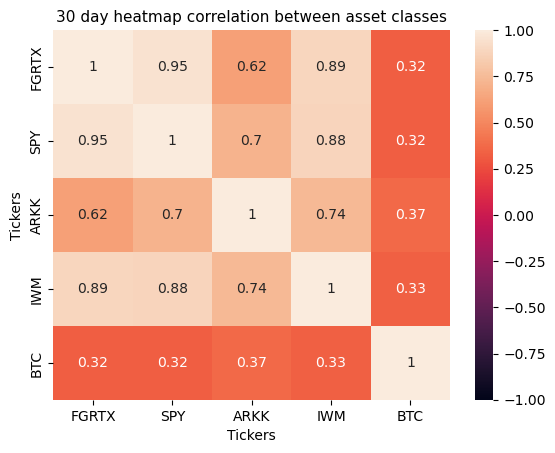

In [41]:
#Plot the correlation
sns_heatmap = sns.heatmap(correlation_join, vmin=-1, vmax=1, annot=True)
sns_heatmap.set_xlabel('Tickers', fontsize=10)
sns_heatmap.set_ylabel('Tickers', fontsize = 10)
sns_heatmap.set_title('30 day heatmap correlation between asset classes', fontsize = 11)

fig = sns_heatmap.get_figure()
fig.savefig("heatmap seaborne")
# swarm_plot = sns.swarmplot(...)
# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

In [42]:
# Calculate the rolling standard deviation for all portfolios using a 30-day window
    #whale portfolio
assets_rollstd_30 =df_daily_returns_all_assets.rolling(window=30).std()
assets_rollstd_30


,FGRTX,SPY,ARKK,IWM,BTC
Date,,,,,
2019-02-19,NaN,NaN,NaN,NaN,NaN
2019-02-20,NaN,NaN,NaN,NaN,NaN
2019-02-21,NaN,NaN,NaN,NaN,NaN
2019-02-22,NaN,NaN,NaN,NaN,NaN
2019-02-25,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-12-22,0.006160,0.006553,0.022758,0.015846,0.028967
2023-12-26,0.005810,0.006110,0.022745,0.015869,0.029469
2023-12-27,0.005816,0.006075,0.022720,0.015838,0.029406


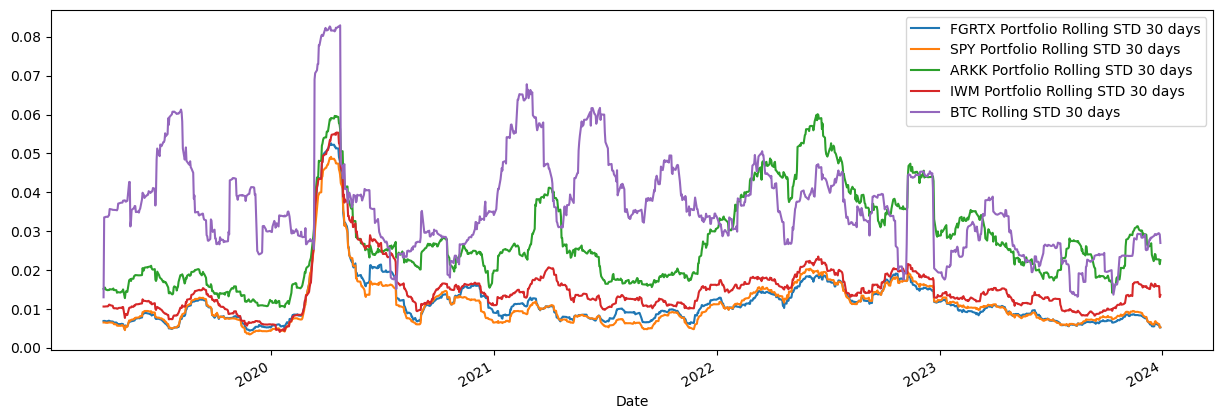

In [43]:
# Plot the rolling standard deviation Whale Portfolio
    
ax = assets_rollstd_30.plot(figsize=(15,5)).legend(["FGRTX Portfolio Rolling STD 30 days", "SPY Portfolio Rolling STD 30 days", "ARKK Portfolio Rolling STD 30 days",
                                                    "IWM Portfolio Rolling STD 30 days","BTC Rolling STD 30 days"])
# Set the legend of the figure
# ax.legend(["FGRTX Portfolio Rolling STD 30 days", "SPY Portfolio Rolling STD 30 days", "ARKK Portfolio Rolling STD 30 days","IWM Portfolio Rolling STD 30 days","BTC Rolling STD 30 days"]);
# ax.title(["Rolling standard Deviations"])

In [44]:
#Calculate and Plot Beta for portfolios and the S&P 500
#Calculate Covariance
#FGRTX
fgrtx_covariance = df_daily_returns_all_assets['FGRTX'].cov(df_daily_returns_all_assets['SPY'])
fgrtx_covariance


0.00016961799479733828

In [45]:
#ARKK
arkk_covariance = df_daily_returns_all_assets['ARKK'].cov(df_daily_returns_all_assets['SPY'])
arkk_covariance

0.00027053282380426903

In [46]:
#IWM
iwm_covariance = df_daily_returns_all_assets['IWM'].cov(df_daily_returns_all_assets['SPY'])
iwm_covariance

0.00019289739866280232

In [47]:
#BTC
btc_covariance = df_daily_returns_all_assets['BTC'].cov(df_daily_returns_all_assets['SPY'])
btc_covariance

0.00016092155178761708

In [48]:
#EFFR daily returnPrices 
daily_returns_effr = effr_df_data_change.pct_change().dropna()
#EFFR
effr_covariance = effr_df_data_change['EFFR % Rate'].cov(df_daily_returns_all_assets['SPY'])
effr_covariance

-2.1918637324978524e-07

In [49]:
# Calculate variance of S&P 500
variance_spy = df_daily_returns_all_assets['SPY'].var()
variance_spy

0.0001706794208093352

In [50]:
# Computing beta FGRTX
fgrtx_beta = fgrtx_covariance / variance_spy
print(f"FGRTX Beta: {fgrtx_beta} ")

#ARKK
arkk_beta = arkk_covariance / variance_spy
print(f"ARKK Beta: {arkk_beta} ")

#IWM
iwm_beta = iwm_covariance / variance_spy
print(f"IWM Beta: {iwm_beta} ")

#BTC
btc_beta = btc_covariance / variance_spy
print(f"BTC Beta: {btc_beta} ")

#EFFR
effr_beta = effr_covariance / variance_spy
print(f"EFFR Beta: {effr_beta} ")


FGRTX Beta: 0.9937811717021079 
ARKK Beta: 1.585034812758589 
IWM Beta: 1.1301737359320352 
BTC Beta: 0.9428292586449624 
EFFR Beta: -0.001284199185879807 


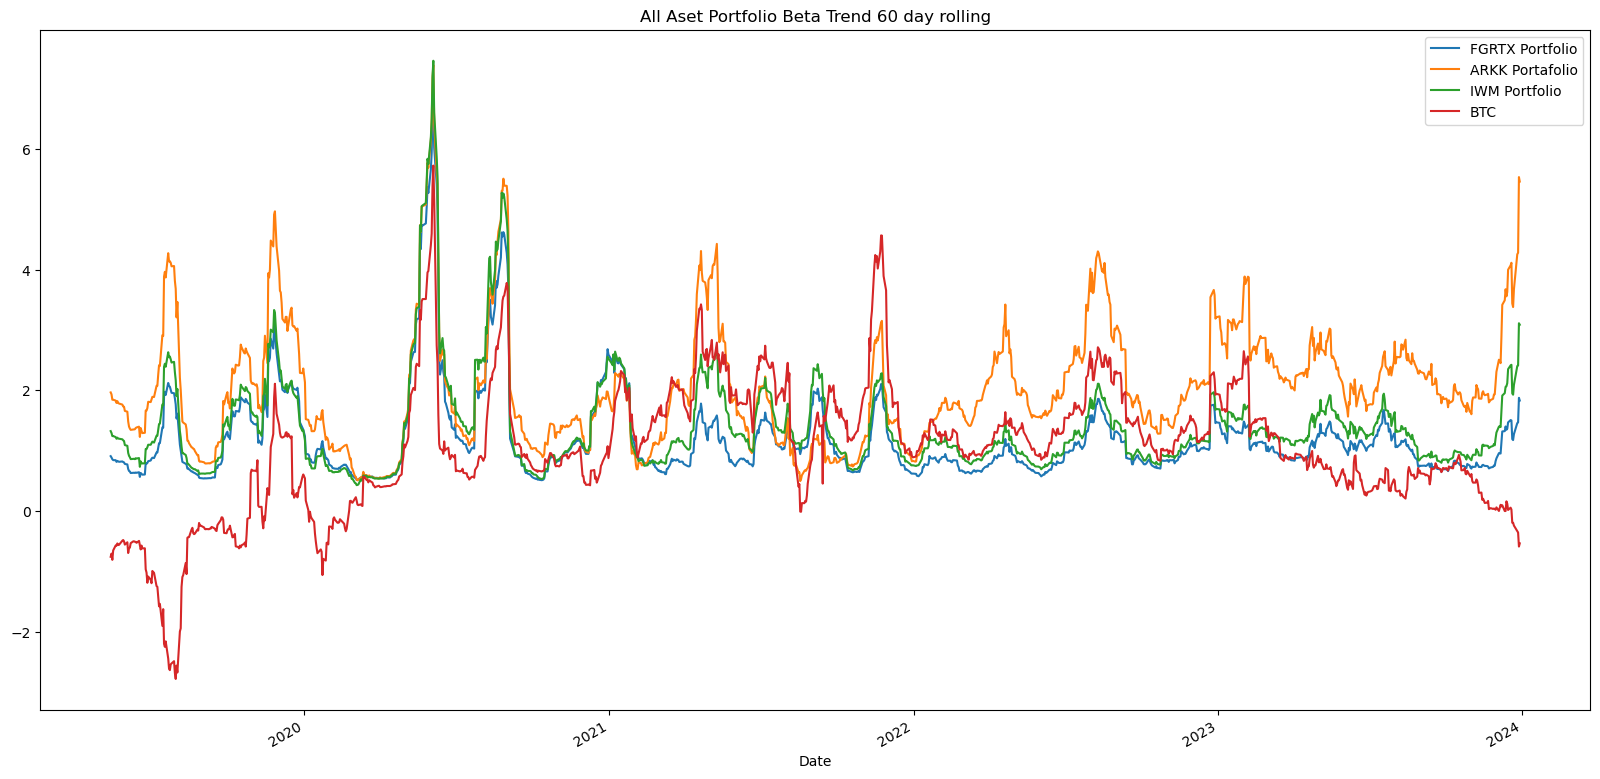

In [51]:
# Plot beta trend 60 days

# Calculate 60-day rolling covariance of Asset classes vs. S&P 500 and plot the data
rolling_fgrtx_covariance = df_daily_returns_all_assets['FGRTX'].rolling(window=60).cov(df_daily_returns_all_assets['SPY'])
rolling_arkk_covariance = df_daily_returns_all_assets['ARKK'].rolling(window=60).cov(df_daily_returns_all_assets['SPY'])
rolling_iwm_covariance = df_daily_returns_all_assets['IWM'].rolling(window=60).cov(df_daily_returns_all_assets['SPY'])
rolling_btc_covariance = df_daily_returns_all_assets['BTC'].rolling(window=60).cov(df_daily_returns_all_assets['SPY'])
rolling_effr_covariance = daily_returns_effr['EFFR % Rate'].rolling(window=60).cov(df_daily_returns_all_assets['SPY'])

# Calculate 60-day rolling variance of S&P 500
rolling_variance_spy = df_daily_returns_all_assets['SPY'].rolling(window=30).var()

# Calculate 60-day rolling beta of Asset classes and plot the data
rolling_fgrtx_beta = rolling_fgrtx_covariance / rolling_variance_spy
rolling_arkk_beta = rolling_arkk_covariance / rolling_variance_spy
rolling_iwm_beta = rolling_iwm_covariance / rolling_variance_spy
rolling_btc_beta = rolling_btc_covariance / rolling_variance_spy
rolling_effr_beta = rolling_effr_covariance / rolling_variance_spy

ax = rolling_fgrtx_beta.plot(figsize=(20, 10), title='All Aset Portfolio Beta Trend 60 day rolling')
rolling_arkk_beta.plot(ax=ax)
rolling_iwm_beta.plot(ax=ax)
rolling_btc_beta.plot(ax=ax)


# Set the legend of the figure
ax.legend(["FGRTX Portfolio", "ARKK Portafolio", "IWM Portfolio", "BTC", "EFFR Portfolio"   ])

In [52]:
effr_df_data_change["EFFR % Rate"].mean()

0.018555847255369927

In [53]:
#The annualized Treynor measure, also known as the reward-to-volatility ratio:
treynor_ratios_fgrtx = ((df_daily_returns_all_assets['FGRTX'].mean() * 252)- effr_df_data_change["EFFR % Rate"].mean())/ fgrtx_beta
treynor_ratios_arkk = ((df_daily_returns_all_assets['ARKK'].mean() * 252) -effr_df_data_change["EFFR % Rate"].mean())/ arkk_beta
treynor_ratios_iwm = ((df_daily_returns_all_assets['IWM'].mean() * 252) -effr_df_data_change["EFFR % Rate"].mean()) / iwm_beta
treynor_ratios_btc = ((df_daily_returns_all_assets['BTC'].mean() * 252) -effr_df_data_change["EFFR % Rate"].mean()) / btc_beta



#treynor_ratios.sort_values(inplace=True)

print(f"FGRTX Treynor Ratio: {treynor_ratios_fgrtx} ")
print(f"ARKK Treynor Ratio: {treynor_ratios_arkk} ")
print(f"IWM Treynor Ratio: {treynor_ratios_iwm} ")
print(f"BTC Treynor Ratio: {treynor_ratios_btc} ")


FGRTX Treynor Ratio: 0.14245397017557218 
ARKK Treynor Ratio: 0.07627358513774643 
IWM Treynor Ratio: 0.0609605833456782 
BTC Treynor Ratio: 0.6042496262784206 


In [69]:
#Graph traynor ratio 
treynor_ratio_setup = [['FGRTX',treynor_ratios_fgrtx],['ARKK',treynor_ratios_arkk],['IWM', treynor_ratios_iwm],
                            ['BTC', treynor_ratios_btc]]

#Putting our data into a dataframe
treynor_df = pd.DataFrame(treynor_ratio_setup, columns = ['Assets','Treynor ratio'])

#Sorting our values
treynor_sort = treynor_df.sort_values("Treynor ratio", axis = 0, ascending = False)

#Setting our index
treynor_df_set = treynor_sort.set_index('Assets')

#Plotting our chart
treynor_df_set.hvplot.bar(title = "Treynor Ratio of Asset Classes", width = 1000)


:Bars   [Assets]   (Treynor ratio)

In [55]:
#https://www.activestate.com/resources/quick-reads/how-to-convert-pandas-to-numpy/ 
#https://realpython.com/linear-regression-in-python/
#Setting the LinearRegression Module:
model = LinearRegression()

#Setting up the dataset for regression: 
df_arkk_spy_iwm_model = df_ARKK_SPY_set.copy()
df_daily_returns_all_assets_model = df_daily_returns_all_assets.copy()

#Declaring my variables
arkk_rsq_setup = df_daily_returns_all_assets_fed["ARKK"].to_numpy()
spy_rsq = df_daily_returns_all_assets_fed["SPY"].to_numpy()
iwm_rsq = df_daily_returns_all_assets_fed["IWM"].to_numpy()
fgrtx_rsq = df_daily_returns_all_assets_fed["FGRTX"].to_numpy()
btc_rsq = df_daily_returns_all_assets_fed["BTC"].to_numpy()
effr_rsq = df_daily_returns_all_assets_fed["EFFR % Rate"].to_numpy()


# Reshaping the dataset
arkk_rsq = arkk_rsq_setup.reshape((-1,1))
spy_rsq = spy_rsq.reshape((-1,1))
iwm_rsq = iwm_rsq.reshape((-1,1))
fgrtx_rsq = fgrtx_rsq.reshape((-1,1))
btc_rsq = btc_rsq.reshape((-1,1))
effr_rsq = effr_rsq.reshape((-1,1))

#Vs. SPX 
model_arkk = LinearRegression().fit(spy_rsq,arkk_rsq) 
model_iwm = LinearRegression().fit(spy_rsq, iwm_rsq)
model_fgrtx = LinearRegression().fit(spy_rsq, fgrtx_rsq)
model_btc = LinearRegression().fit(spy_rsq, btc_rsq)

#Vs. Fed 
fed_v_arkk = LinearRegression().fit(effr_rsq, arkk_rsq)
fed_v_spy = LinearRegression().fit(effr_rsq,spy_rsq)
fed_v_iwm = LinearRegression().fit(effr_rsq,iwm_rsq)
fed_v_fgrtx = LinearRegression().fit(effr_rsq,fgrtx_rsq)
fed_v_btc = LinearRegression().fit(effr_rsq, btc_rsq)


# model_effr_spx = LinearRegression().fit(effr_rsq, spy_rsq)
# print(len(effr_rsq),len(spy_rsq),len(arkk_rsq),len(iwm_rsq),len(fgrtx_rsq),len(btc_rsq), len(effr_rsq))

#Vs. EFFR
# model_effr_arkk = LinearRegression().fit(effr_rsq, arkk_rsq)

#Getting R-Square between SPX & Other asset Classes(correlation co-efficient) 
r_sq_arkk = model_arkk.score(spy_rsq,arkk_rsq)
r_sq_iwm = model_iwm.score(spy_rsq, iwm_rsq)
r_sq_fgrtx = model_fgrtx.score(spy_rsq, fgrtx_rsq)
r_sq_btc = model_btc.score(spy_rsq, btc_rsq)


#Getting R-Square between Fed Fund rate & change in other assets 
fed_v_arkk_score = fed_v_arkk.score(effr_rsq, arkk_rsq)
fed_v_spy_score = fed_v_spy.score(effr_rsq, spy_rsq)
fed_v_iwm_score = fed_v_iwm.score(effr_rsq, iwm_rsq)
fed_v_fgrtx_score = fed_v_fgrtx.score(effr_rsq, fgrtx_rsq)
fed_v_btc_score = fed_v_btc.score(effr_rsq, btc_rsq)

#Printing the correlations out between the S&P500 to other asset classes daily returns 
print(f"r2 of SPX to ARKK is {r_sq_arkk}")
print(f"r2 of SPX to IWM is {r_sq_iwm}")
print(f"r2 of SPX to FGRTX is {r_sq_fgrtx}")
print(f"r2 of SPX to BTC is {r_sq_btc}")

#Printing the correlation of the Fed Fund Rate vs. all other asset classes daily returns
print(f"R2 FED to ARKK is {fed_v_arkk_score}")
print(f"R2 FED to SPY is {fed_v_spy_score}")
print(f"R2 FED to IWM is {fed_v_iwm_score}")
print(f"R2 FED to FGRTX is {fed_v_fgrtx_score}")
print(f"R2 FED to BTC is {fed_v_btc_score}")

#Findings: The Fed Fund Rate has extremely weak-form correlation 


r2 of SPX to ARKK is 0.4972084328415167
r2 of SPX to IWM is 0.7705144748747007
r2 of SPX to FGRTX is 0.9067321538581636
r2 of SPX to BTC is 0.1034946666765445
R2 FED to ARKK is 0.00011584694385546879
R2 FED to SPY is 7.566457681518202e-07
R2 FED to IWM is 7.58708519363882e-05
R2 FED to FGRTX is 3.7842676715582613e-06
R2 FED to BTC is 2.5834367996746543e-05


In [72]:
#Preparing our SPX vs. Asset classes correlation: 
data_correl_barchart_SPX = [['S&P500 correlated to ARKK',r_sq_arkk],['S&P500 correlated to IWM',r_sq_iwm],['S&P500 correlated to FGRTX', r_sq_fgrtx], ['S&P500 correlated to BTC', r_sq_btc]]

#Putting our data_col_heads as a dataframe 
df_spx_correlation_assets = pd.DataFrame(data_correl_barchart_SPX, columns = ['S&P500 versus Assets over 1200+ trading days', 'Correlation coefficient'])

df_spx_correlation_assets_sorted = df_spx_correlation_assets.sort_values("Correlation coefficient", axis = 0, ascending = False)

#Setting our index 
df_correl_assets_spx = df_spx_correlation_assets_sorted.set_index("S&P500 versus Assets over 1200+ trading days")
# df_correl_assets_spx.head()

#Plotting our chart
df_correl_assets_spx.hvplot.bar(title = "Correlation of the S&P500 versus other asset classes")




:Bars   [S&P500 versus Assets over 1200+ trading days]   (Correlation coefficient)

In [81]:
#Preparing our Fed Fund Rate vs. Asset classes correlation
data_correl_barchart_fff = [['Fed Fund Rate vs. ARKK daily returns',fed_v_arkk_score],['Fed Fund Rate vs. S&P500 daily returns',fed_v_spy_score],['Fed Fund Rate vs. IWM daily returns', fed_v_iwm_score],
                            ['Fed Fund Rate vs. FGRTX daily returns', fed_v_fgrtx_score],['Fed Fund Rate vs. Bitcoin daily returns',fed_v_btc_score]]

#Putting our data into a dataframe
df_data_correlation_fff = pd.DataFrame(data_correl_barchart_fff, columns = ['Fed Fund Rate vs. Daily Returns of Asset Classes','Correlation Coefficient'])

#Sorting our values
df_data_correlated_fff_sorted = df_data_correlation_fff.sort_values("Correlation Coefficient", axis = 0, ascending = False)

#Setting our index
df_data_correlation_fff_set = df_data_correlated_fff_sorted.set_index('Fed Fund Rate vs. Daily Returns of Asset Classes')
# df_data_correlation_fff_set.head()




#Plotting our chart
df_data_correlation_fff_set.hvplot.bar(title = "Correlation between the Fed Fund Rate vs. Asset Classes Daily Returns", width = 1000) #Heatmap 



:Bars   [Fed Fund Rate vs. Daily Returns of Asset Classes]   (Correlation Coefficient)

In [58]:
# Annualized Sharpe Ratios
sharpe_ratios = (df_daily_returns_all_assets.mean() * 252) / (df_daily_returns_all_assets.std() * np.sqrt(252))
sharpe_ratios.sort_values(ascending = False, inplace=True)
sharpe_ratios

# Visualize the sharpe ratios as a bar plot
sharpe_ratios.hvplot.bar(title = "Asset classes Sharpe Ratio",ascending = False, xlabel = "Asset Classes", ylabel = "Sharpe Ratio")




:Bars   [index]   (0)